#  Machine learning :XGBoost, KNN,Naive baies,RandomForest
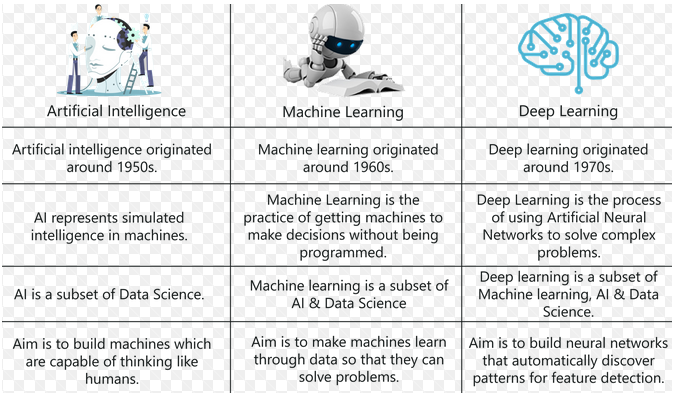

### Machine learning:
Ml is a subset of artificial intelligence that uses techniques (such as deep learning) that enable machines to use experience to improve at tasks. The learning process is based on the following steps:

   - Feed data into an algorithm. (In this step you can provide additional information to the model, for example, by performing feature extraction.)
   - Use this data to train a model.
   - Test and deploy the model.
   - Consume the deployed model to do an automated predictive task. (In other words, call and use the deployed model to receive the predictions returned by the model.)

###  Evaluation: 

1) Use F1-score as the evaluation metric in such cases(highly imbalanced data).

2) Use stratified sampling while train_test split.

3) Try one vs rest classifier.

4) Use algorithms like ,Knn ,Naive baya ,xgboost, lightgbm and catboost.



In [1]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
from pyspark.context import SparkContext 
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()#create spark session 
sc = spark.sparkContext#create sparkContext
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                                DecimalType,
                                LongType,
                                ArrayType,
                                TimestampType)
sample_schema = StructType([StructField("id",  IntegerType(), True),
                            StructField("timeAtServer", DoubleType(), True),
                            StructField("aircraft",  IntegerType(), True ),
                            StructField("latitude", DoubleType(), True),
                            StructField("longitude", DoubleType(), True  ),
                            StructField("baroAltitude", DoubleType(), True ),
                            StructField("geoAltitude", DoubleType(), True ),
                            StructField("numM",IntegerType(), True),
                            StructField("measurements", StringType(), True)           
                            ])
sample_aircarft = spark.read.csv("C:/PFE/TEST/training_1_category_1.csv",
                       header = True, 
                        schema = sample_schema)

sample_aircarft_filtred=sample_aircarft.filter((sample_aircarft.latitude !=0) & (sample_aircarft.longitude != 0) & (sample_aircarft.baroAltitude != 0)& (sample_aircarft.measurements != 'NA'))

In [2]:
sorted_flights =sample_aircarft.orderBy('aircraft','timeAtServer')
sensors_schema = StructType([StructField("serial", LongType(), True),
                            StructField("latitudes", DoubleType(), True ),
                            StructField("longitudes",DoubleType(), True),
                            StructField("height",DoubleType(), True),
                            StructField("type", StringType(), True)
                            ])
sensors = spark.read.csv("C:/PFE/TEST/sensors.csv",
                       header = True, 
                        schema = sensors_schema)
from  pyspark.sql.functions import isnan
sample_aircarft.na.drop(how = 'all')
sample_aircarft.dropDuplicates()
sample_aircarft_filtred=sample_aircarft.filter((sample_aircarft.latitude !=0) & (sample_aircarft.longitude != 0) & (sample_aircarft.baroAltitude != 0)& (sample_aircarft.measurements != 'NA'))
sensors.na.drop(how = 'all')
sensors.dropDuplicates()
sensors_filtred=sensors.filter((sensors.latitudes !=0) & (sensors.longitudes != 0))
#let's check our work !
sample_aircarft_filtred.filter((sample_aircarft_filtred["latitude"] == "") | sample_aircarft_filtred["latitude"].isNull() | isnan(sample_aircarft_filtred["latitude"])).count()
#Amazing  we have 0 null , nan  values !!!! #eleminating null data 
sample_aircarft.na.drop(how = 'all')
sample_aircarft.dropDuplicates()
from pyspark.sql.functions import *
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("ArrayOfString",
                                                             split(col("measurements"), "\],\s*\[").cast(ArrayType(StringType())).alias("ArrayOfString"))                                           
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("sensors_informations",
                                                             
                                                             explode_outer('ArrayOfString'))
sample_aircarft_filtred=sample_aircarft_filtred.withColumn("sensors_informations",
                                                           regexp_replace(col("sensors_informations"), "[\\[\\]]", ""))
sample_aircarft_filtred=sample_aircarft_filtred.withColumn("sensors_informations",
                                                           split(col("sensors_informations"), ",\s*").cast(ArrayType(IntegerType())).alias("sensors informations"))
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("serial_F",
                                                             sample_aircarft_filtred["sensors_informations"].getItem(0))
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("timestamp",
                                                             sample_aircarft_filtred["sensors_informations"].getItem(1))
sample_aircarft_filtred= sample_aircarft_filtred.withColumn("signalstrength",
                                                            sample_aircarft_filtred["sensors_informations"].getItem(2))
#==>Data integration: Using multiple databases
#spatial join sesnors data + aircrafts data , i used inner join 
joined_aircarft_sensors=sample_aircarft_filtred.join(sensors_filtred,
                                                     sample_aircarft_filtred.serial_F == sensors_filtred.serial, 'inner')


### -Geohash lenght and distance error:

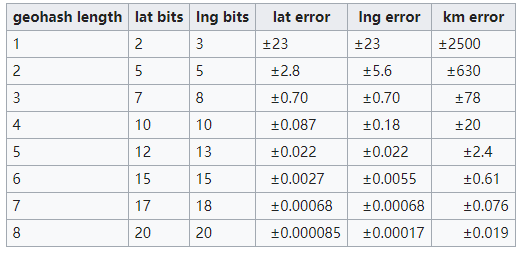

### -Input DataTranformation:

In [3]:
import geohash2
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
#to create geohash positions we  need float num (lat, long)
joined_aircarft_sensors.baroAltitude.cast(DoubleType())
joined_aircarft_sensors.geoAltitude.cast(DoubleType())
joined_aircarft_sensors.height.cast(DoubleType())
joined_aircarft_sensors.latitude.cast(DoubleType()) 
joined_aircarft_sensors.longitude.cast(DoubleType()) 
joined_aircarft_sensors.latitudes.cast(DoubleType()) 
joined_aircarft_sensors.longitudes.cast(DoubleType()) 
#we will create geohash with precision of 12 bit 
udf1 = F.udf(lambda x,y: geohash2.encode(x,y,precision=5))
udf2= F.udf(lambda x,y,z,t: geodesic((x,y),(z,t)))
joined_aircarft_sensors=joined_aircarft_sensors.withColumn('Geohash_aircraft', udf1('latitude','longitude'))
joined_aircarft_sensors=joined_aircarft_sensors.withColumn('Geohash__sensors', udf1('latitudes','longitudes'))
def get_Difference( alt1, alt2): 
    Difference= alt1-alt2
    return Difference
udf_get_Difference = F.udf(get_Difference)
joined_aircarft_sensors=joined_aircarft_sensors.withColumn('height-baro', 
                                                           udf_get_Difference('baroAltitude','height').cast(DoubleType()))

### -Stratified sampling of geohash distinct class:

In [ ]:
fractions = joined_aircarft_sensors.select("Geohash_aircraft").distinct().withColumn("fraction",
                                                                                     lit(0.5)).rdd.collectAsMap()
sampled_aircarft_sensors = joined_aircarft_sensors.stat.sampleBy("Geohash_aircraft", fractions)

In [ ]:
import plotly.graph_objs as go
import pandas as pd
import requests
import matplotlib.pyplot as plt
sampled_aircarft_sensors=sampled_aircarft_sensors.select('baroAltitude','numM'
                                                         ,'serial_F','signalstrength'
                                                         ,'timestamp','latitudes'
                                                         ,'longitudes','height'
                                                         ,'type','height-baro'
                                                         ,'Geohash__sensors','Geohash_aircraft')
import pandas as pd
%matplotlib inline
aircarft_sensors_pandas_DataFrame = pd.DataFrame.from_records(sampled_aircarft_sensors.collect()
                                                              , columns=sampled_aircarft_sensors.columns)

### -Input Data  Shape:

In [ ]:
aircarft_sensors_pandas_DataFrame.shape

In [ ]:
aircarft_sensors_pandas_DataFrame.head(5)

### -Feautres engineer - Feautres selections :
###### -correlations of each features in dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
X = aircarft_sensors_pandas_DataFrame.iloc[:,0:20]  #independent columns
y = aircarft_sensors_pandas_DataFrame.iloc[:,-1]    #target column i.e 
#get correlations of each features in dataset
corrmat = aircarft_sensors_pandas_DataFrame.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(aircarft_sensors_pandas_DataFrame[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
import pandas as pd
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from math import sqrt
from sklearn.metrics import mean_squared_error
aircarft_sensors_pandas_DataFrame=aircarft_sensors_pandas_DataFrame.dropna()
#aircarft_sensors_pandas_DataFrame=aircarft_sensors_pandas_DataFrame.groupby(['Geohash_aircraft']).filter(lambda x: x['Geohash_aircraft'].eq(1).sum() >= 2)
X = aircarft_sensors_pandas_DataFrame.iloc[:,0:11]
y = aircarft_sensors_pandas_DataFrame.iloc[:,-1]
y.head(3)

### -String to index:

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X.iloc[:, 10] = labelencoder_X_1.fit_transform(X.iloc[:, 10])
labelencoder_X_2 = LabelEncoder()
X.iloc[:, 8] = labelencoder_X_2.fit_transform(X.iloc[:, 8])
X.head()

In [ ]:
labelencoder_X_3 = LabelEncoder()
y = labelencoder_X_3.fit_transform(y)
y[0:10]

### -Scaling Features:
When you’re working with a learning model, it is important to scale the features to a range which is centered around zero. Scaling will make sure the variance of the features are in the same range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler =MinMaxScaler()
X= scaler.fit_transform(X)

X[0:2,]


### -10 best features:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(aircarft_sensors_pandas_DataFrame.iloc[:,0:11].columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

### -Unique Geohash class:

In [ ]:
 np.unique(y, axis=0)

# sklearn.models:
### 1-Model:XGBoost
**XGBoost** (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting algorithm.
What differentiates it from other boosting algorithms is its speed and accuracy
Extreme Gradient Boosting (XGBoost) is a more efficient version of gradient boosting framework containing both a linear model solver and tree learning algorithms.

The reason behind it’s efficiency is it’s capacity to do parallel computing on a single machine.

The problem with general boosting was

   - Can’t extract the linear combination of features
   - Small predictive power (high variance)

It used GBT approach that included

   - control tree structure (maximum depth, minimum samples per leaf),
   - control learning rate (shrinkage),
   - reduce variance by introducing randomness (stochastic gradient boosting – using random subsamples of instances and features)

XGBoost improved it with some good features like-

   - good bias-variance (simple-predictive) trade-off “out of the box”,
   - great computation speed

XGBoost’s objective function is a sum of a specific loss function evaluated overall predictions and a sum of regularization term for all predictors (KK trees).

Mathematically,
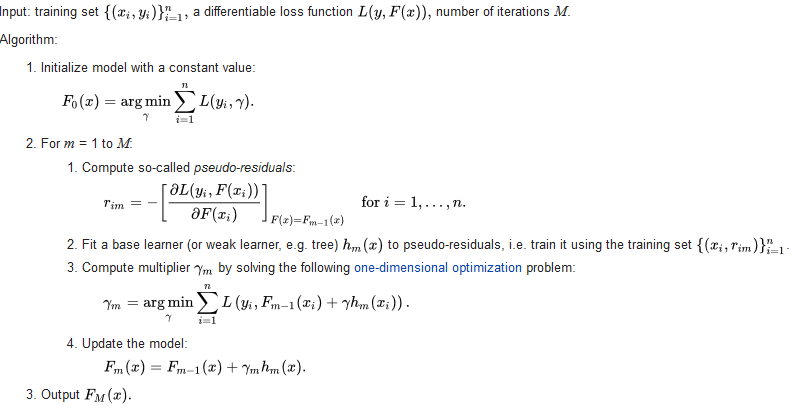

XGBoost handles only numeric variables.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1)
import xgboost
classifier = xgboost.XGBClassifier()
classifier.fit(X_train, y_train.ravel())



In [ ]:
# examine class distribution
unique, counts = np.unique(y_test, return_counts=True)
print( np.asarray((unique, counts)))

In [ ]:
import matplotlib.pyplot as plt

print(classifier.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(classifier.feature_importances_, index=aircarft_sensors_pandas_DataFrame.iloc[:,0:11].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
# make predictions for test data
y_pred_class = classifier.predict(X_test)
y_pred=classifier.predict(X_train)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_class, normalize=True)
print('Test accuracy score:',accuracy)
print('Train accuracy score:',accuracy_score(y_train,classifier.predict(X_train)))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_class,pos_label='positive',
                                           average='micro')
print('F1 score: %f' % f1)

### 2-Model:Multinomial Logistic Regression



In multinomial logistic regression (MLR) the logistic function  is replaced with a softmax function:

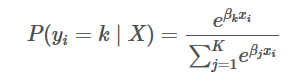

where P(yi=k∣X)
is the probability the ith observation’s target value, yi, is class k, and K is the total number of classes. One practical advantage of the MLR is that its predicted probabilities using the predict_proba method are more reliable 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression( multi_class='multinomial', solver='newton-cg')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_train)
y_pred_class=logreg.predict(X_test)
print('Train accuracy score:',accuracy_score(y_train,y_pred))
print('Test accuracy score:', accuracy_score(y_test,logreg.predict(X_test)))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_class,pos_label='positive',
                                           average='micro')
print('F1 score: %f' % f1)

In [ ]:
from sklearn.metrics import *
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_class,pos_label='positive',
                                           average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_class,pos_label='positive',
                                           average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_class,pos_label='positive',
                                           average='micro')
print('F1 score: %f' % f1)

### 3- Random forest classifier 
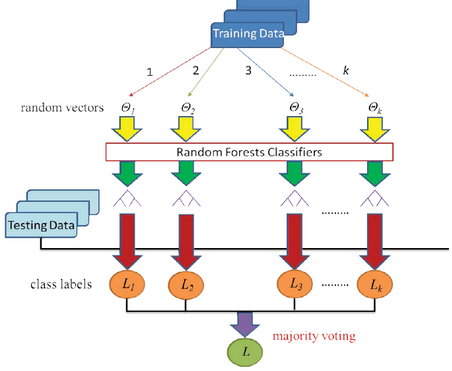

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc_b = RFC()
rfc_b.fit(X_train,y_train)
y_pred = rfc_b.predict(X_train)
y_pred_class = rfc_b.predict(X_test)
print('Train accuracy score:',accuracy_score(y_train,y_pred))
print('Test accuracy score:', accuracy_score(y_test,rfc_b.predict(X_test)))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_class,pos_label='positive',
                                           average='micro')
print('F1 score: %f' % f1)

### 4- Model K-Nearest Neighbors:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(1)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_train)
y_pred_class=knn.predict(X_test)
print('Train accuracy score:',accuracy_score(y_train,y_pred))
print('Test accuracy score:',accuracy_score(y_test,knn.predict(X_test)))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_class,pos_label='positive',
                                           average='micro')
print('F1 score: %f' % f1)

### 5-Model Naive bayes :
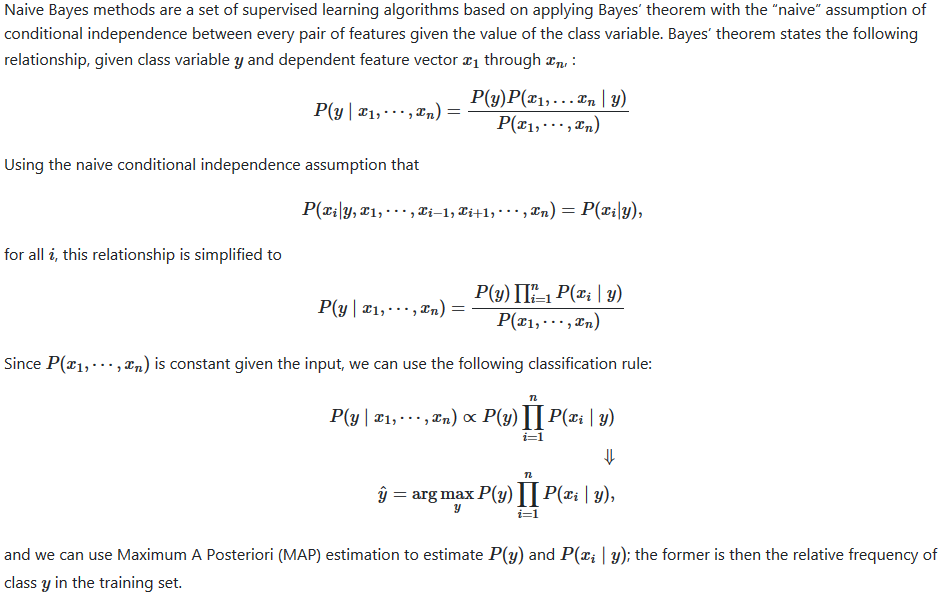

1.**Gaussian NB**: It should be used for features in decimal form. GNB assumes features to follow a normal distribution.

2.**MultiNomial NB**: It should be used for the features with discrete values like word count 1,2,3...

3.**Bernoulli NB**: It should be used for features with binary or boolean values like True/False or 0/1


In [ ]:
# 1. import
from sklearn.naive_bayes import MultinomialNB
# 2. instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()
%time nb.fit(X_train,y_train)

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
B = BernoulliNB()

%time B.fit(X_train,y_train)
y_pred_classB = B.predict(X_test)

metrics.accuracy_score(y_test, y_pred_classB)

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
G=GaussianNB()
%time G.fit(X_train,y_train)
y_pred_classg = G.predict(X_test)
metrics.accuracy_score(y_test, y_pred_classg)

In [ ]:
# 4. make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test)
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)


In [ ]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_class,pos_label='positive',
                                           average='micro')
print('F1 score: %f' % f1)

 - we will chose **XGBOOST** because it have the heighest score:
 - Let's validate our model:

### -Cross-Valudation , CV=10

In [ ]:
import xgboost as xgb
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
params = {"objective":'multi:softprob','num_class':341,'colsample_bytree':1,'learning_rate':0.1,
                'max_depth':8, 'alpha':0}
cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=10)
cv_results.head(10)

In [ ]:
cv_results['train-merror-mean'].mean(),cv_results['test-merror-mean'].mean()

In [ ]:
import pdfkit
pdfkit.from_file('C:/PFE/RapportLatex/MachineLearningModels.html', 'C:/PFE/RapportLatex/MachineLearningModels.pdf')